On part avec ce carnet de notes sur la réalisation **d'une carte du patrimoine excentré de Nancy**, un peu sur le modèle de ce que j'avais fait il y a quelques années [pour Rue89 Strasbourg](http://www.rue89strasbourg.com/deux-balades-pour-decouvrir-le-patrimoine-excentre-de-strasbourg-65236).

La carte finale inclura non seulement une sélection de monuments, mais aussi **un parcours optimal pour les découvrir à pied**.

Les données de base ont été récoltées en scrapant Wikipedia, avec une recette directement inspirée [de ce tuto](http://raphi.m0le.net/blog/sraper-wikipedia-python.html).

Une fois le csv prêt à l'emploi, on va le manipuler avec la librairie pandas pour ensuite le traduire en fichier géo avec geopandas :

In [1]:
%matplotlib inline
# la ligne précédente, c'est pour que ça affiche correctement l'image dans un notebook ipython ou Jupyter
import pandas as pd
import fiona
import networkx as nx
import math
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
ox.config(log_console=True, use_cache=True) # ça c'est juste pour voir OSMnx bosser en direct dans le terminal

fichier = pd.read_csv("monuments_histo_nancy.csv", sep = ",")
fichier = fichier.sort_values(by=('Latitude'), ascending = True)
fichier.head()

ModuleNotFoundError: No module named 'osmnx'

La variable fichier est propre, mais pas encore lisible par la bibliothèque geopandas. Pour cela, il faut un peu la malaxer **en rassemblant les valeurs des des colonnes "Longitude" et "Latitude"** dans une nouvelle colonne.

Concrètement, ça nous donne :

In [2]:
geometrie = [Point(xy) for xy in zip(fichier.Longitude, fichier.Latitude)] # cette liste de point sera bien interprétée par gpd
fichier_geo = gp.GeoDataFrame(fichier, crs=None, geometry=geometrie)

fichier_geo.head()

,Monument,Adresse,Longitude,Latitude,Source,geometry
163,Villa Bonnabel,"107, 111 avenue du Général-Leclerc",6.176700,48.675400,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.1767 48.6754)
10,Eglise Notre-Dame-Bonsecours,254 avenue de Strasbourg,6.199400,48.676700,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.1994 48.6767)
102,Maison,25 rue Félix-Faure,6.166077,48.678037,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.166077 48.678037)
105,Maison,30 rue Félix-Faure,6.165711,48.678149,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.165711 48.678149)
104,Maison,28 rue Félix-Faure,6.165782,48.678170,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.165782 48.67817)


On peut dès lors cartographier les différents points contenus dans fichier_geo. Il suffit d'utiliser ces commandes :

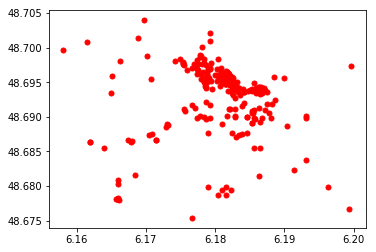

In [3]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

fichier_geo.plot(ax=ax, marker='o', color='red', markersize=5)

On remarque **une agrégation de monuments historiques autour d'une zone "centrale"**. Pour faire une purge rapide et ne garder que le patrimoine excentré, une méthode simple consiste à :

* définir un **point central**
* lui donner un certain rayon
* **virer tous les marqueurs empiétant sur sa surface**

On va d'abord visualiser ce centre et lui donner une zone d'influence :

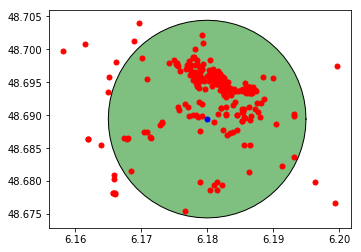

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

fichier_geo.plot(ax=ax, marker='o', color='red', markersize=5)
#on est obligé de repasser par les lignes précédentes pour afficher convenablement la carte

coord_centre = [Point(6.18, 48.689420)]
centre = gp.GeoDataFrame(crs=None, geometry=coord_centre)
centre.plot(ax=ax, color = 'blue',markersize=5)

cercle = gp.GeoDataFrame(crs=None, geometry=centre.buffer(0.015))
# concrètement on crée une surface qui va englober plusieurs points
cercle.plot(ax=ax, color = 'green')

Il ne reste plus qu'à créer **une nouvelle GeoDataFrame avec les points qui ne sont pas à l'intérieur du cercle** pour rassembler le patrimoine excentré dans une même variable :

Nombre de monuments : 262
Monuments centraux : 242
Patrimoine excentrée : 20


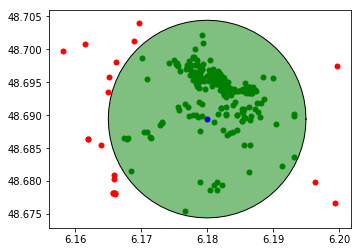

In [5]:
points_int = gp.sjoin(fichier_geo,cercle, how = "inner")
points_ext = fichier_geo[~fichier_geo.index.isin(points_int.index)]

fig, ax = plt.subplots()
ax.set_aspect('equal')
cercle.plot(color = 'green',ax=ax)
centre.plot(ax=ax,color = 'blue', markersize=5)
points_int.plot(ax=ax,marker='o', color='green', markersize=5)
points_ext.plot(ax=ax,marker='o', color='red', markersize=5)

print('Nombre de monuments :' ,len(fichier_geo))
print('Monuments centraux :' ,len(points_int))
print('Patrimoine excentrée :' ,len(points_ext))

Côté tableur, cela donne :

In [6]:
points_ext.head()

,Monument,Adresse,Longitude,Latitude,Source,geometry
10,Eglise Notre-Dame-Bonsecours,254 avenue de Strasbourg,6.199400,48.676700,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.1994 48.6767)
102,Maison,25 rue Félix-Faure,6.166077,48.678037,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.166077 48.678037)
105,Maison,30 rue Félix-Faure,6.165711,48.678149,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.165711 48.678149)
104,Maison,28 rue Félix-Faure,6.165782,48.678170,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.165782 48.67817)
103,Maison,26 rue Félix-Faure,6.165853,48.678192,http://www.culture.gouv.fr/public/mistral/meri...,POINT (6.165853 48.678192)


Tout semble correc', il ne nous reste plus qu'à enregistrer notre patrimoine excentré **dans un format spécifique**. Le JSON est une bonne option !

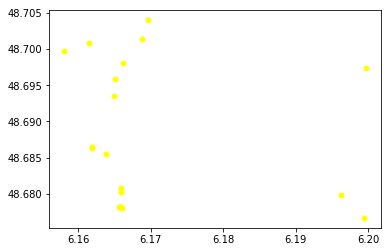

In [7]:
with open('patex_nancy.json', 'w') as f:
    f.write(points_ext.to_json())
    

points_ext.plot(marker='o', color='yellow', markersize=5)

Il va falloir se pencher **sur un tri satisfaisant**. Le problèmme est le suivant : la bibliothèque OSMNx déterminera bien le trajet le plus court entre deux points, mais si ces derniers sont rangés de façon aléatoire on aura pas de circuit à l'arrivée. Donc : il faut **ranger les points par étapes cohérentes** !

Pour ce faire, je reproduis l'algo [proposé par Marjan Moderc sur StackOverflow](https://stackoverflow.com/questions/40873279/geopandas-sort-a-sample-of-points-like-a-cycle-graph) :

In [12]:
points_ext.crs = {'init' :'epsg:4326'}

liste_points = points_ext[["Longitude","Latitude"]].values.tolist()
points_ranges = gp.GeoDataFrame(columns=points_ext.columns)

# on crée ensuite deux nouvelles variables, une qui trie les listes par longitude (x[0]), l'autre par latitude (x[1])
points_oe = sorted(liste_points, key=lambda x: x[0])
points_sn = sorted(liste_points, key=lambda x: x[1])

ouest_plus = points_oe[0]
est_plus = points_oe[-1]

deltay = est_plus[1] - ouest_plus[1]
deltax = est_plus[0] - ouest_plus[0]

alfa = math.degrees(math.atan2(deltay, deltax))
azimut = (90 - alfa) % 360

if (azimut > 45 and azimut < 135):
    liste_points = points_oe
elif azimut > 180:
    raise Exception("Erreur en compilant la variable azimut ! Elle ne peut pas être supérieure à 180...")
else:
    liste_points = points_sn

points_ranges = points_ranges.append(points_ext.ix[(points_ext["Longitude"]==liste_points[0][0]) & (points_ext["Latitude"]==liste_points[0][1])])

for i in range(0, len(liste_points) - 1):
    deja_ranges = points_ranges[["Longitude","Latitude"]].values.tolist()
    point_actuel = deja_ranges[-1]
    possibles_candidats = [i for i in liste_points if i not in deja_ranges]
    distance = 10000000000000000000000
    meilleur_candidat = ""
    for candidat in possibles_candidats:
        distance_actuelle = Point(point_actuel).distance(Point(candidat))
        if distance_actuelle < distance:
            meilleur_candidat = candidat
            distance = distance_actuelle
    points_ranges = points_ranges.append(points_ext.ix[(points_ext["Longitude"]==meilleur_candidat[0]) & (points_ext["Latitude"]==meilleur_candidat[1])])

# on va remettre à zéro liste_points pour ne retenir  que les duos lagitutde/longitude de notre parcours

with open('points_ranges.json', 'w') as f:
    f.write(points_ranges.to_json())

liste_points = []

for ligne in points_ranges.iterrows():
    petite_liste = []
    petite_liste.append(ligne[1][2])
    petite_liste.append(ligne[1][3])
    liste_points.append(petite_liste)

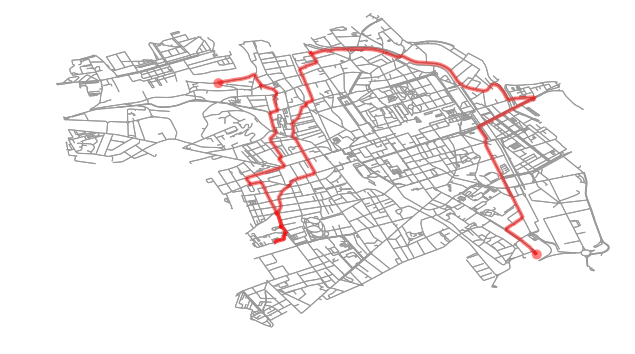

In [9]:
route = []

G = ox.graph_from_place('Nancy, France', network_type='walk')
route = []

for point1, point2 in zip(liste_points[:-1], liste_points[1:]):
    orig = ox.get_nearest_node(G, tuple(reversed(point1)))
    dest = ox.get_nearest_node(G, tuple(reversed(point2)))
    intermediate_route = nx.shortest_path(G, orig, dest, weight='length')
    route.extend(intermediate_route[:-1]) 
    
route.append(dest)
fig, ax = ox.plot_graph_route(G, route, node_size=0)

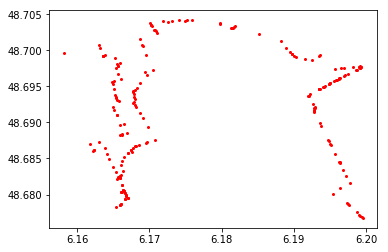

In [10]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

output_points = gdf_nodes.loc[route]
output_points.plot(color='red')

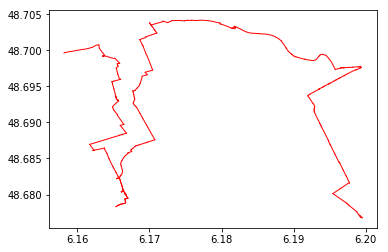

In [11]:
gdf_edges.index = gdf_edges.apply(lambda row: (row.u, row.v), axis=1)
output_lines = gdf_edges.loc[list(zip(route[:-1], route[1:]))]
output_lines.plot(color='red')

In [14]:
sch = {'geometry': 'LineString',
       'properties': {'key': 'int',
                        'u': 'int',
                        'v': 'int'}}

test = gp.GeoDataFrame(output_lines[['u', 'v', 'key']], 
                        geometry=output_lines['geometry'], crs='+init=EPSG:3740')

test.to_file('parcours.shp', schema=sch)